In [1]:
import numpy as np
import argparse
from copy import deepcopy
import torch
import gym
import time
from normalized_env import NormalizedEnv
from evaluator import Evaluator
from ddpg import DDPG
from wolp import WOLPAgent
from util import *
from ContinuousCartPole import ContinuousCartPoleEnv

In [2]:
def train(num_iterations, agent, env,  evaluate, validate_steps, output, max_episode_length=None, debug=False):

    agent.is_training = True
    step = episode = episode_steps = 0
    episode_reward = 0.
    observation = None
    while step < num_iterations:
        # reset if it is the start of episode
        if observation is None:
            observation = deepcopy(env.reset())
            agent.reset(observation)

        # agent pick action ...        
        
        if step <= args.warmup:
            action = agent.random_action()
        else:
            action = agent.select_action(observation)
        
        # env response with next_observation, reward, terminate_info
        observation2, reward, done, info = env.step(action)
        observation2 = deepcopy(observation2)
        if max_episode_length and episode_steps >= max_episode_length -1:
            done = True

        # agent observe and update policy
        agent.observe(reward, observation2, done)
        if step > args.warmup:
            agent.update_policy()
        
        # [optional] evaluate
        if evaluate is not None and validate_steps > 0 and step % validate_steps == 0:
            policy = lambda x: agent.select_action(x, decay_epsilon=False)
            validate_reward = evaluate(env, policy, debug=False, visualize=False)
            if debug: prYellow('[Evaluate] Step_{:07d}: mean_reward:{}'.format(step, validate_reward))

        # [optional] save intermideate model
        if step % int(num_iterations/3) == 0:
            agent.save_model(output)

        # update 
        step += 1
        episode_steps += 1
        episode_reward += reward
        observation = deepcopy(observation2)

        if done: # end of episode
            if debug: prGreen('#{}: episode_reward:{} steps:{}'.format(episode,episode_reward,step))

            agent.memory.append(
                observation,
                agent.select_action(observation),
                0., False
            )

            # reset
            observation = None
            episode_steps = 0
            episode_reward = 0.
            episode += 1

In [3]:
def test(num_episodes, agent, env, evaluate, model_path, visualize=True, debug=False):

    agent.load_weights(model_path)
    agent.is_training = False
    agent.eval()
    policy = lambda x: agent.select_action(x, decay_epsilon=False)

    for i in range(num_episodes):
        validate_reward = evaluate(env, policy, debug=debug, visualize=visualize, save=False)
        if debug: prYellow('[Evaluate] #{}: mean_reward:{}'.format(i, validate_reward))

In [4]:
class Arguments(object):
    def __init__(self):
        self.mode = 'train'
        self.env = "InvertedPendulum-v2"
        self.hidden1 = 400
        self.hidden2 = 300
        self.rate = 0.001
        self.prate = 0.0001
        self.warmup = 100
        self.discount = 0.99
        self.bsize = 64
        self.rmsize = 6000000
        self.window_length = 1
        self.tau = 0.001
        self.ou_theta = 0.15
        self.ou_sigma = 0.2
        self.ou_mu = 0.0
        self.validate_episodes = 20
        self.max_episode_length = 500
        self.validate_steps = 2000
        self.output = 'output'
        self.debug='debug'
        self.init_w = 0.003
        self.train_iter=20000
        self.epsilon=50000
        self.seed=-1
        self.max_actions=1e6
        self.resume='default'
        self.k_ratio = 1e-6

args = Arguments()

 [Evaluate] Step_0000000: mean_reward:15.6
 #0: episode_reward:1.0 steps:2
 #1: episode_reward:38.0 steps:40
 #2: episode_reward:7.0 steps:47
 #3: episode_reward:18.0 steps:65
 #4: episode_reward:14.0 steps:79
 #5: episode_reward:16.0 steps:95
 #6: episode_reward:11.0 steps:106


/home/nikhil/anaconda3/envs/opencv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: 
You are calling 'step()' even though this environment has already returned
done = True. You should always call 'reset()' once you receive 'done = True'
Any further steps are undefined behavior.
                
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nikhil/sem7/TML/Project/TOML/ghliu_final/util.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  torch.from_numpy(ndarray), volatile=volatile, requires_grad=requires_grad
/home/nikhil/sem7/TML/Project/TOML/ghliu_final/wolp.py:84: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_q_values.volatile=False


 #7: episode_reward:13.0 steps:119
 #8: episode_reward:37.0 steps:156
 #9: episode_reward:10.0 steps:166
 #10: episode_reward:8.0 steps:174
 #11: episode_reward:8.0 steps:182
 #12: episode_reward:7.0 steps:189
 #13: episode_reward:7.0 steps:196
 #14: episode_reward:6.0 steps:202
 #15: episode_reward:7.0 steps:209
 #16: episode_reward:7.0 steps:216
 #17: episode_reward:6.0 steps:222
 #18: episode_reward:6.0 steps:228
 #19: episode_reward:6.0 steps:234
 #20: episode_reward:6.0 steps:240
 #21: episode_reward:7.0 steps:247
 #22: episode_reward:7.0 steps:254
 #23: episode_reward:6.0 steps:260
 #24: episode_reward:6.0 steps:266
 #25: episode_reward:6.0 steps:272
 #26: episode_reward:5.0 steps:277
 #27: episode_reward:6.0 steps:283
 #28: episode_reward:6.0 steps:289
 #29: episode_reward:6.0 steps:295
 #30: episode_reward:6.0 steps:301
 #31: episode_reward:6.0 steps:307
 #32: episode_reward:6.0 steps:313
 #33: episode_reward:6.0 steps:319
 #34: episode_reward:5.0 steps:324
 #35: episode_reward

 #188: episode_reward:6.0 steps:1220
 #189: episode_reward:6.0 steps:1226
 #190: episode_reward:6.0 steps:1232
 #191: episode_reward:6.0 steps:1238
 #192: episode_reward:5.0 steps:1243
 #193: episode_reward:6.0 steps:1249
 #194: episode_reward:6.0 steps:1255
 #195: episode_reward:6.0 steps:1261
 #196: episode_reward:6.0 steps:1267
 #197: episode_reward:5.0 steps:1272
 #198: episode_reward:6.0 steps:1278
 #199: episode_reward:5.0 steps:1283
 #200: episode_reward:5.0 steps:1288
 #201: episode_reward:6.0 steps:1294
 #202: episode_reward:6.0 steps:1300
 #203: episode_reward:5.0 steps:1305
 #204: episode_reward:6.0 steps:1311
 #205: episode_reward:5.0 steps:1316
 #206: episode_reward:6.0 steps:1322
 #207: episode_reward:6.0 steps:1328
 #208: episode_reward:6.0 steps:1334
 #209: episode_reward:6.0 steps:1340
 #210: episode_reward:6.0 steps:1346
 #211: episode_reward:6.0 steps:1352
 #212: episode_reward:5.0 steps:1357
 #213: episode_reward:5.0 steps:1362
 #214: episode_reward:6.0 steps:1368
 

 #364: episode_reward:6.0 steps:2245
 #365: episode_reward:7.0 steps:2252
 #366: episode_reward:6.0 steps:2258
 #367: episode_reward:6.0 steps:2264
 #368: episode_reward:6.0 steps:2270
 #369: episode_reward:6.0 steps:2276
 #370: episode_reward:6.0 steps:2282
 #371: episode_reward:5.0 steps:2287
 #372: episode_reward:6.0 steps:2293
 #373: episode_reward:6.0 steps:2299
 #374: episode_reward:7.0 steps:2306
 #375: episode_reward:5.0 steps:2311
 #376: episode_reward:5.0 steps:2316
 #377: episode_reward:5.0 steps:2321
 #378: episode_reward:5.0 steps:2326
 #379: episode_reward:6.0 steps:2332
 #380: episode_reward:6.0 steps:2338
 #381: episode_reward:6.0 steps:2344
 #382: episode_reward:5.0 steps:2349
 #383: episode_reward:6.0 steps:2355
 #384: episode_reward:7.0 steps:2362
 #385: episode_reward:6.0 steps:2368
 #386: episode_reward:6.0 steps:2374
 #387: episode_reward:6.0 steps:2380
 #388: episode_reward:5.0 steps:2385
 #389: episode_reward:6.0 steps:2391
 #390: episode_reward:5.0 steps:2396
 

 #539: episode_reward:5.0 steps:3267
 #540: episode_reward:7.0 steps:3274
 #541: episode_reward:6.0 steps:3280
 #542: episode_reward:6.0 steps:3286
 #543: episode_reward:6.0 steps:3292
 #544: episode_reward:6.0 steps:3298
 #545: episode_reward:5.0 steps:3303
 #546: episode_reward:6.0 steps:3309
 #547: episode_reward:6.0 steps:3315
 #548: episode_reward:6.0 steps:3321
 #549: episode_reward:6.0 steps:3327
 #550: episode_reward:6.0 steps:3333
 #551: episode_reward:6.0 steps:3339
 #552: episode_reward:6.0 steps:3345
 #553: episode_reward:7.0 steps:3352
 #554: episode_reward:6.0 steps:3358
 #555: episode_reward:6.0 steps:3364
 #556: episode_reward:6.0 steps:3370
 #557: episode_reward:6.0 steps:3376
 #558: episode_reward:6.0 steps:3382
 #559: episode_reward:6.0 steps:3388
 #560: episode_reward:6.0 steps:3394
 #561: episode_reward:6.0 steps:3400
 #562: episode_reward:6.0 steps:3406
 #563: episode_reward:6.0 steps:3412
 #564: episode_reward:6.0 steps:3418
 #565: episode_reward:7.0 steps:3425
 

 #714: episode_reward:6.0 steps:4298
 #715: episode_reward:6.0 steps:4304
 #716: episode_reward:7.0 steps:4311
 #717: episode_reward:6.0 steps:4317
 #718: episode_reward:5.0 steps:4322
 #719: episode_reward:6.0 steps:4328
 #720: episode_reward:6.0 steps:4334
 #721: episode_reward:7.0 steps:4341
 #722: episode_reward:6.0 steps:4347
 #723: episode_reward:6.0 steps:4353
 #724: episode_reward:6.0 steps:4359
 #725: episode_reward:6.0 steps:4365
 #726: episode_reward:6.0 steps:4371
 #727: episode_reward:6.0 steps:4377
 #728: episode_reward:6.0 steps:4383
 #729: episode_reward:6.0 steps:4389
 #730: episode_reward:6.0 steps:4395
 #731: episode_reward:6.0 steps:4401
 #732: episode_reward:5.0 steps:4406
 #733: episode_reward:5.0 steps:4411
 #734: episode_reward:6.0 steps:4417
 #735: episode_reward:6.0 steps:4423
 #736: episode_reward:6.0 steps:4429
 #737: episode_reward:6.0 steps:4435
 #738: episode_reward:6.0 steps:4441
 #739: episode_reward:6.0 steps:4447
 #740: episode_reward:7.0 steps:4454
 

 #889: episode_reward:6.0 steps:5325
 #890: episode_reward:6.0 steps:5331
 #891: episode_reward:6.0 steps:5337
 #892: episode_reward:5.0 steps:5342
 #893: episode_reward:6.0 steps:5348
 #894: episode_reward:6.0 steps:5354
 #895: episode_reward:6.0 steps:5360
 #896: episode_reward:6.0 steps:5366
 #897: episode_reward:6.0 steps:5372
 #898: episode_reward:6.0 steps:5378
 #899: episode_reward:6.0 steps:5384
 #900: episode_reward:6.0 steps:5390
 #901: episode_reward:6.0 steps:5396
 #902: episode_reward:5.0 steps:5401
 #903: episode_reward:6.0 steps:5407
 #904: episode_reward:6.0 steps:5413
 #905: episode_reward:6.0 steps:5419
 #906: episode_reward:6.0 steps:5425
 #907: episode_reward:6.0 steps:5431
 #908: episode_reward:7.0 steps:5438
 #909: episode_reward:6.0 steps:5444
 #910: episode_reward:6.0 steps:5450
 #911: episode_reward:6.0 steps:5456
 #912: episode_reward:6.0 steps:5462
 #913: episode_reward:6.0 steps:5468
 #914: episode_reward:6.0 steps:5474
 #915: episode_reward:6.0 steps:5480
 

 #1062: episode_reward:7.0 steps:6349
 #1063: episode_reward:6.0 steps:6355
 #1064: episode_reward:6.0 steps:6361
 #1065: episode_reward:6.0 steps:6367
 #1066: episode_reward:6.0 steps:6373
 #1067: episode_reward:6.0 steps:6379
 #1068: episode_reward:6.0 steps:6385
 #1069: episode_reward:6.0 steps:6391
 #1070: episode_reward:6.0 steps:6397
 #1071: episode_reward:6.0 steps:6403
 #1072: episode_reward:5.0 steps:6408
 #1073: episode_reward:5.0 steps:6413
 #1074: episode_reward:6.0 steps:6419
 #1075: episode_reward:6.0 steps:6425
 #1076: episode_reward:6.0 steps:6431
 #1077: episode_reward:6.0 steps:6437
 #1078: episode_reward:6.0 steps:6443
 #1079: episode_reward:6.0 steps:6449
 #1080: episode_reward:5.0 steps:6454
 #1081: episode_reward:6.0 steps:6460
 #1082: episode_reward:5.0 steps:6465
 #1083: episode_reward:6.0 steps:6471
 #1084: episode_reward:6.0 steps:6477
 #1085: episode_reward:6.0 steps:6483
 #1086: episode_reward:6.0 steps:6489
 #1087: episode_reward:6.0 steps:6495
 #1088: epis

 #1235: episode_reward:5.0 steps:7358
 #1236: episode_reward:6.0 steps:7364
 #1237: episode_reward:6.0 steps:7370
 #1238: episode_reward:6.0 steps:7376
 #1239: episode_reward:5.0 steps:7381
 #1240: episode_reward:5.0 steps:7386
 #1241: episode_reward:6.0 steps:7392
 #1242: episode_reward:6.0 steps:7398
 #1243: episode_reward:6.0 steps:7404
 #1244: episode_reward:6.0 steps:7410
 #1245: episode_reward:6.0 steps:7416
 #1246: episode_reward:6.0 steps:7422
 #1247: episode_reward:6.0 steps:7428
 #1248: episode_reward:6.0 steps:7434
 #1249: episode_reward:6.0 steps:7440
 #1250: episode_reward:6.0 steps:7446
 #1251: episode_reward:6.0 steps:7452
 #1252: episode_reward:6.0 steps:7458
 #1253: episode_reward:6.0 steps:7464
 #1254: episode_reward:6.0 steps:7470
 #1255: episode_reward:6.0 steps:7476
 #1256: episode_reward:6.0 steps:7482
 #1257: episode_reward:5.0 steps:7487
 #1258: episode_reward:6.0 steps:7493
 #1259: episode_reward:6.0 steps:7499
 #1260: episode_reward:7.0 steps:7506
 #1261: epis

 #1405: episode_reward:5.0 steps:8352
 #1406: episode_reward:7.0 steps:8359
 #1407: episode_reward:6.0 steps:8365
 #1408: episode_reward:6.0 steps:8371
 #1409: episode_reward:6.0 steps:8377
 #1410: episode_reward:6.0 steps:8383
 #1411: episode_reward:6.0 steps:8389
 #1412: episode_reward:6.0 steps:8395
 #1413: episode_reward:6.0 steps:8401
 #1414: episode_reward:6.0 steps:8407
 #1415: episode_reward:6.0 steps:8413
 #1416: episode_reward:6.0 steps:8419
 #1417: episode_reward:6.0 steps:8425
 #1418: episode_reward:6.0 steps:8431
 #1419: episode_reward:6.0 steps:8437
 #1420: episode_reward:6.0 steps:8443
 #1421: episode_reward:6.0 steps:8449
 #1422: episode_reward:6.0 steps:8455
 #1423: episode_reward:6.0 steps:8461
 #1424: episode_reward:6.0 steps:8467
 #1425: episode_reward:6.0 steps:8473
 #1426: episode_reward:6.0 steps:8479
 #1427: episode_reward:6.0 steps:8485
 #1428: episode_reward:6.0 steps:8491
 #1429: episode_reward:6.0 steps:8497
 #1430: episode_reward:6.0 steps:8503
 #1431: epis

 #1577: episode_reward:6.0 steps:9361
 #1578: episode_reward:6.0 steps:9367
 #1579: episode_reward:6.0 steps:9373
 #1580: episode_reward:6.0 steps:9379
 #1581: episode_reward:6.0 steps:9385
 #1582: episode_reward:6.0 steps:9391
 #1583: episode_reward:5.0 steps:9396
 #1584: episode_reward:5.0 steps:9401
 #1585: episode_reward:6.0 steps:9407
 #1586: episode_reward:5.0 steps:9412
 #1587: episode_reward:6.0 steps:9418
 #1588: episode_reward:6.0 steps:9424
 #1589: episode_reward:6.0 steps:9430
 #1590: episode_reward:5.0 steps:9435
 #1591: episode_reward:6.0 steps:9441
 #1592: episode_reward:5.0 steps:9446
 #1593: episode_reward:6.0 steps:9452
 #1594: episode_reward:6.0 steps:9458
 #1595: episode_reward:6.0 steps:9464
 #1596: episode_reward:6.0 steps:9470
 #1597: episode_reward:6.0 steps:9476
 #1598: episode_reward:6.0 steps:9482
 #1599: episode_reward:6.0 steps:9488
 #1600: episode_reward:6.0 steps:9494
 #1601: episode_reward:6.0 steps:9500
 #1602: episode_reward:6.0 steps:9506
 #1603: epis

 #1747: episode_reward:6.0 steps:10363
 #1748: episode_reward:6.0 steps:10369
 #1749: episode_reward:6.0 steps:10375
 #1750: episode_reward:6.0 steps:10381
 #1751: episode_reward:6.0 steps:10387
 #1752: episode_reward:6.0 steps:10393
 #1753: episode_reward:6.0 steps:10399
 #1754: episode_reward:6.0 steps:10405
 #1755: episode_reward:6.0 steps:10411
 #1756: episode_reward:6.0 steps:10417
 #1757: episode_reward:6.0 steps:10423
 #1758: episode_reward:5.0 steps:10428
 #1759: episode_reward:6.0 steps:10434
 #1760: episode_reward:6.0 steps:10440
 #1761: episode_reward:6.0 steps:10446
 #1762: episode_reward:6.0 steps:10452
 #1763: episode_reward:6.0 steps:10458
 #1764: episode_reward:7.0 steps:10465
 #1765: episode_reward:6.0 steps:10471
 #1766: episode_reward:6.0 steps:10477
 #1767: episode_reward:6.0 steps:10483
 #1768: episode_reward:6.0 steps:10489
 #1769: episode_reward:5.0 steps:10494
 #1770: episode_reward:6.0 steps:10500
 #1771: episode_reward:6.0 steps:10506
 #1772: episode_reward:6.

 #1912: episode_reward:28.0 steps:12611
 #1913: episode_reward:28.0 steps:12639
 #1914: episode_reward:26.0 steps:12665
 #1915: episode_reward:22.0 steps:12687
 #1916: episode_reward:16.0 steps:12703
 #1917: episode_reward:18.0 steps:12721
 #1918: episode_reward:27.0 steps:12748
 #1919: episode_reward:22.0 steps:12770
 #1920: episode_reward:22.0 steps:12792
 #1921: episode_reward:17.0 steps:12809
 #1922: episode_reward:25.0 steps:12834
 #1923: episode_reward:25.0 steps:12859
 #1924: episode_reward:21.0 steps:12880
 #1925: episode_reward:27.0 steps:12907
 #1926: episode_reward:18.0 steps:12925
 #1927: episode_reward:28.0 steps:12953
 #1928: episode_reward:24.0 steps:12977
 #1929: episode_reward:28.0 steps:13005
 #1930: episode_reward:20.0 steps:13025
 #1931: episode_reward:18.0 steps:13043
 #1932: episode_reward:32.0 steps:13075
 #1933: episode_reward:30.0 steps:13105
 #1934: episode_reward:17.0 steps:13122
 #1935: episode_reward:35.0 steps:13157
 #1936: episode_reward:18.0 steps:13175


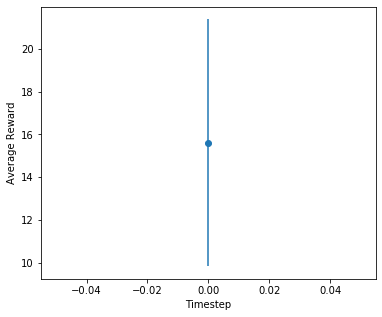

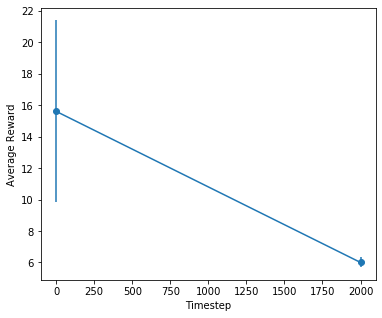

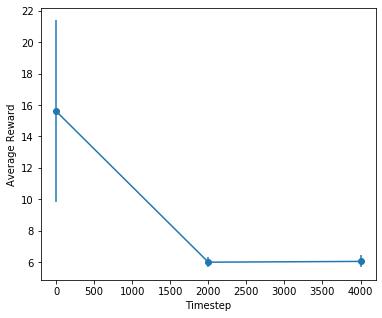

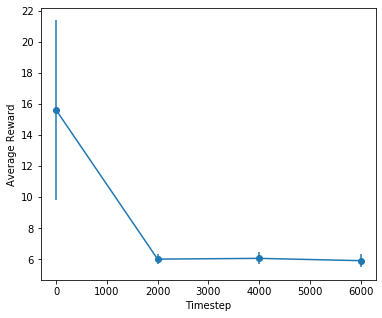

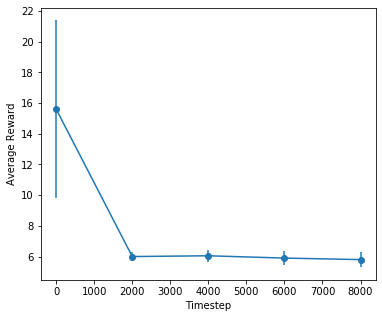

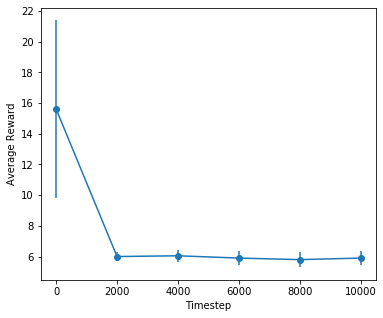

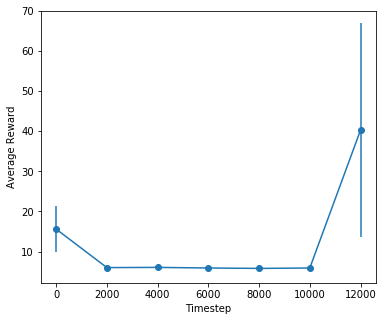

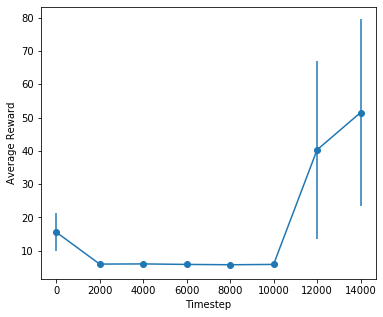

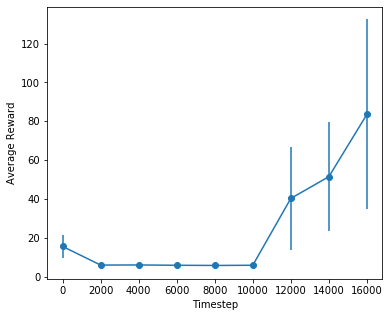

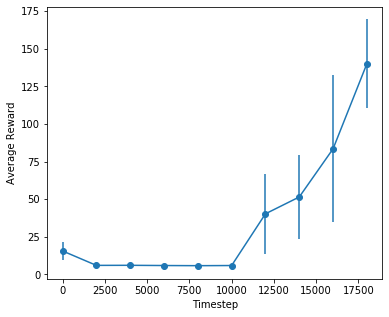

In [5]:
args.output = get_output_folder(args.output, args.env)
if args.resume == 'default':
    args.resume = 'output/{}-run0'.format(args.env)

# env = NormalizedEnv(gym.make(args.env))
# env = gym.make(args.env)
env = ContinuousCartPoleEnv()
#################################### Our Code ##############################
args.low = env.action_space.low
args.high = env.action_space.high
#################################### Our Code ##############################

if args.seed > 0:
    np.random.seed(args.seed)
    env.seed(args.seed)

nb_states = env.observation_space.shape[0]
nb_actions = env.action_space.shape[0]


agent = WOLPAgent(nb_states, nb_actions, args)
evaluate = Evaluator(args.validate_episodes, 
    args.validate_steps, args.output, max_episode_length=args.max_episode_length)

start_time = time.time()

if args.mode == 'train':
    train(args.train_iter, agent, env, evaluate, 
        args.validate_steps, args.output, max_episode_length=args.max_episode_length, debug=args.debug)
    end_time = time.time()

elif args.mode == 'test':
    test(args.validate_episodes, agent, env, evaluate, args.resume,
        visualize=True, debug=args.debug)

else:
    raise RuntimeError('undefined mode {}'.format(args.mode))